In [154]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import random

In [228]:
corpus_name = "OpenSubtitle"
save_dir = os.path.join("data", "save")
corpus = "./data/es.txt"

def printLines(stop=10, decode=False):
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            
            if decode:
                print(i,line.decode("utf-8"))
            else:
                print(i,line)
            if i==stop: break

printLines(1050,True)

0 NETKonet trae para ti...

1 "Twenty"

2 [NEW Presenta]

3 [Una producción de A M Tree Pictures]

4 [Sidus HQ]

5 [Productor ejecutivo:

6 Kim Woo Taek]

7 Somos los típicos amigos de la secundaria que juraron que su amistad duraría para siempre.

8 Aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros.

9 Ejem... ejem.

10 Ejem...

11 [Encuéntrate conmigo en el patio de atrás.]

12 - ¿Le acariciaste el pecho a Fo Min?

13 - No.

14 No se lo acaricié, me quede allí parado tocándolo.

15 - Debes estar demente.

16 - ¿Eso es una pregunta?

17 ¿Crees que fue una pregunta, idiota?

18 Ey, que ya no somos niños.

19 ¿En qué estaban pensando para pelear así por una chica?

20 Deben resolverlo de forma razonable.

21 - Háganlo con Piedra, Papel o tijeras.

22 - Es una buena idea. ¡Hagámoslo!

23 Ok, solo haremos una ronda, como hombres.

24 ¡Piedra, papel o tijeras!

25 Un hombre de verdad usa una piedra.

26 ¡Piedra, pape

858 Es demasiado duro.

859 Tan solo métete en los negocios.

860 No, eso tampoco.

861 Es muy difícil.

862 Tener un pequeño negocio es muy duro, si puedes, simplemente sé rico.

863 El gobierno es bueno con los ricos.

864 Tan solo haz eso.

865 Y luego cásate con un una linda actriz.

866 Y si las cosas no salen bien, divórciate y vuelve a casarte.

867 Vuelve a casarte tanto como quieras.

868 ¿No suena bien eso?

869 ¡Director!

870 ¡Le pedí que viniera!

871 ¿No puedes ver que estoy yendo?

872 Estoy en camino... hacia ti.

873 Ese idiota es un imbécil.

874 Siempre mandoneándome.

875 Cree que él es el director.

876 - ¿Por qué tardó tanto, Director?

877 - No te escuché.

878 ¿Entonces por qué respondió?

879 Ahí va de nuevo.

880 Levántese.

881 Levántese.

882 - ¿Qué querías que viera?

883 - Venga por aquí.

884 Es genial.

885 Eso fue hermoso.

886 [CEO Kim:

887 Club Rosa en Cheongdam-dong, Miércoles a las 9 pm.]

888 El análisis lo es todo en las inversiones.

889 El novi

In [6]:
n_lines = 0
with open(corpus, 'rb') as file:
    for line in file:
        n_lines += 1
print(f'Numero de líneas: {n_lines}')

Numero de líneas: 213517354


In [255]:
#funcion para buscar ejemplos a la hora de tratar la puntuacion
def search_line(search_string,stop=10):
    n=0
    prev_line,line_found = "",""
    prnt = False
    
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            if prnt:
                print("-------------")
                print(prev_line.decode("utf-8"),line_found.decode("utf-8"),
                      line.decode("utf-8"), sep="\n")
                prnt = False
                n+=1
                if n==stop:
                    break
            if search_string in line: 
                line_found = line
                prnt = True
            else:
                prev_line = line
search_line(b".000")

-------------
Ey, Cha Chi Ho.

Dijiste que tu meta en la vida es dormir con 3.000 mujeres antes de morir.

¿Entonces cómo es que aún no me has puesto ni un dedo encima?

-------------
- ¿Veis esta manita?

Pues valdrá unas 3.000 libras.

¿Quién es el idiota ahora?

-------------
Las estadísticas específicas son escandalosas.

De 26.000 patentes aplicadas en África en 2000 y en 2001, sólo 31 fueron de personas residentes en África.

El resto fue de residentes de países del primer mundo.

-------------
El resto fue de residentes de países del primer mundo.

31 de 26.000 solicitudes de patentes.

No es lo que yo esperaba.

-------------
Lo que el Sr. Sprat dijo hoy es una gran señal de esperanza respecto a lo que todos aspiramos lograr, que es una economía que beneficie a todos.

El anuncio de la disolución de la OMC fue enviado por Yes Men a 25.000 periodistas, políticos y agencias de noticias del mundo.

Ahora, tras un análisis protegido, prolongado y detallado...

-------------
Todas l

In [263]:
#Procesado de la puntuación
def processLine(s):
    s = s.strip().lower().decode()
    s = re.sub(r"\.000",r" mil", s)
    s = re.sub(r"^-",       r"<GUION_INIC>", s)
    s = re.sub(r"-{2}",     r"<GUION_DOBL>", s)
    s = re.sub(r"\.{3}",    r"<TRIP_DOT>", s)
    s = re.sub(r"(\w)-(\w)",r"\1<GUION_INTER>\2", s)
    s = re.sub(r"([\).:!?])", r" \1", s) #separa puntuacion con espacio antes
    s = re.sub(r"([\(¡¿])", r"\1 ", s)   #separa puntuacion con espacio despues
    s = re.sub(r"([\"-,])", r" \1 ", s)  #espacio antes y despues
    #separa los tokens
    s = re.sub(r"<", r" <", s)
    s = re.sub(r">", r"> ", s)
    
    s = re.sub(r"\s<GUION_INTER>\s",r"-", s)
    return s

#Test 0
print(processLine("-t. -t".encode()))
#Test 1:
print(processLine("t. ¿t?".encode()))
#Test 2:
print(processLine("t... ¿¿¿t???".encode()))
#Test 3:
print(processLine("...t ...".encode()))
#Test 4:
print(processLine("???...!!!".encode()))
#Test 5
print(processLine('"¿Cómo?"'.encode()))
#Test 6
print(processLine('(--8:)'.encode()))
#Test 7
print(processLine('electro-quimico'.encode()))
#Test 8
print(processLine('que--'.encode()))
#Test 9
print(processLine('-ivanov'.encode()))
#Test 10
print(processLine('10.000, 5:45'.encode()))

 <GUION_INIC> t . -t
t . ¿ t ?
t <TRIP_DOT>  ¿ ¿ ¿ t ? ? ?
 <TRIP_DOT> t  <TRIP_DOT> 
 ? ? ? <TRIP_DOT>  ! ! !
 " ¿ cómo ? " 
 (   <GUION_DOBL> 8 :  ) 
electro-quimico
que <GUION_DOBL> 
 <GUION_INIC> ivanov
10 mil ,  5 :45


In [264]:
MAX_LENGTH=20
def loadLines(file, total_lines=10, max_lenght=MAX_LENGTH):
    with open(file, 'rb') as datafile:
        n=0
        for i,line in enumerate(datafile):
            if max(line.find(b"["),line.find(b"]")) == -1: #filtra los comentarios
                s = processLine(line)
                if len(s.split(' ')) < max_lenght: #filtra frases largas
                    n+=1
                    yield i,s
            if n==total_lines: break
                
for i,l in loadLines(corpus,100): print(i,l)

0 netkonet trae para ti <TRIP_DOT> 
1  " twenty " 
7 somos los típicos amigos de la secundaria que juraron que su amistad duraría para siempre .
8 aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros .
9 ejem <TRIP_DOT>  ejem .
10 ejem <TRIP_DOT> 
12  <GUION_INIC>  ¿ le acariciaste el pecho a fo min ?
13  <GUION_INIC>  no .
14 no se lo acaricié ,  me quede allí parado tocándolo .
15  <GUION_INIC>  debes estar demente .
16  <GUION_INIC>  ¿ eso es una pregunta ?
17 ¿ crees que fue una pregunta ,  idiota ?
18 ey ,  que ya no somos niños .
19 ¿ en qué estaban pensando para pelear así por una chica ?
20 deben resolverlo de forma razonable .
21  <GUION_INIC>  háganlo con piedra ,  papel o tijeras .
22  <GUION_INIC>  es una buena idea . ¡ hagámoslo !
23 ok ,  solo haremos una ronda ,  como hombres .
24 ¡ piedra ,  papel o tijeras !
25 un hombre de verdad usa una piedra .
26 ¡ piedra ,  papel o tijeras !
27 hagámoslo de nue

In [155]:
#lineas usadas sobre el total
lines_used = 500_000 #determina el tamaño de la parte de dataset que cogemos
f"{lines_used/n_lines:.3%}"

'0.234%'

In [152]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print(f"keep_words {len(keep_words)} / { len(self.word2index)} = "
              f"{len(keep_words) / len(self.word2index):.4f}")

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

53327


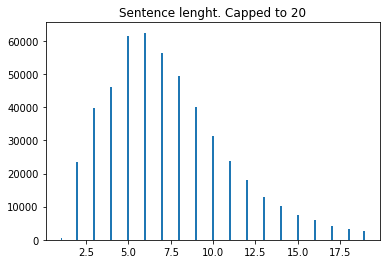

In [272]:
#TODO: multithread
voc = Voc(corpus_name)

hist = []  
for i,s in loadLines(corpus,lines_used):
    s_l = len(s.split(' '))
    hist.append(s_l)
    voc.addSentence(s)
    
print(voc.num_words)

arr = np.array(hist)
plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
plt.title(f"Sentence lenght. Capped to {MAX_LENGTH}")
plt.show()

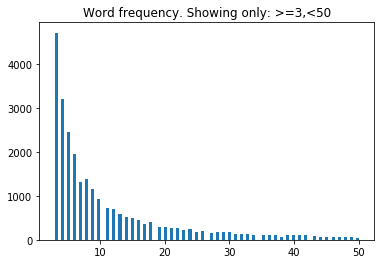

In [266]:
hist=[]
for i,n in enumerate(voc.word2count):
    c = voc.word2count[n]
    if c>=3:
        hist.append(c)
        
arr = np.array(hist)
plt.hist(arr, bins=100,range=(3,50))  # arguments are passed to np.histogram
plt.title(f"Word frequency. Showing only: >=3,<50")
plt.show()

In [267]:
from collections import Counter
c = Counter(voc.word2count)
c.most_common()

[('', 357391),
 ('.', 344855),
 (',', 136179),
 ('<GUION_INIC>', 95547),
 ('?', 94775),
 ('¿', 88838),
 ('no', 78745),
 ('que', 73921),
 ('de', 69029),
 ('a', 55258),
 ('la', 50561),
 ('el', 44202),
 ('!', 42132),
 ('es', 39177),
 ('¡', 38148),
 ('y', 36264),
 ('lo', 34247),
 ('en', 33523),
 ('un', 32518),
 ('qué', 28482),
 ('me', 27733),
 ('por', 26929),
 ('<TRIP_DOT>', 24315),
 ('se', 20623),
 ('una', 20431),
 ('te', 17563),
 ('los', 16676),
 ('con', 16388),
 ('sí', 15602),
 ('está', 13998),
 ('para', 13563),
 ('si', 13246),
 ('pero', 13206),
 ('le', 12783),
 ('yo', 12361),
 ('su', 11965),
 ('mi', 11850),
 ('las', 11725),
 ('al', 10717),
 ('eso', 10519),
 ('bien', 10302),
 ('ha', 9888),
 ('aquí', 9731),
 ('más', 9372),
 ('"', 9365),
 ('del', 9164),
 ('ya', 8200),
 ('como', 8099),
 ('muy', 7515),
 ('todo', 7303),
 ('he', 7301),
 ('señor', 7080),
 ('usted', 6317),
 ('hay', 6221),
 ('nada', 6219),
 ('ahora', 5847),
 ('tu', 5789),
 ('tiene', 5722),
 ('gracias', 5635),
 ('cómo', 5576),
 (

In [269]:
for word in c:
    for punt in ",.¿?¡!\":()-":
        if punt in word:
            if len(word)>1 and c[word]>3:
                print(c[word],"\t", word)

6 	 .c
7 	 .l
20 	 .b
164 	 :30
16 	 .m
325 	 :00
6 	 .00
10 	 .v
9 	 :05
6 	 c-47
5 	 1-7
18 	 1-9-0
34 	 :45
31 	 .500
5 	 bangkok-rangoon
5 	 0-1-2-3-4-5-6-7
5 	 beri-beri
5 	 febrero-mayo
4 	 mount-lavinia
24 	 .uu
5 	 la-di-dah
5 	 vive-bien
5 	 .estafadores
9 	 .200
101 	 brogan-moore
42 	 bate-huevos
24 	 :26
6 	 240-130
6 	 ama-dama
60 	 :25
63 	 :10
18 	 :40
5 	 alemán-húngaro
16 	 -¿
16 	 -¿
9 	 .r
5 	 m-47
8 	 .800
6 	 bx-89
10 	 mt-3
5 	 .400
37 	 anne-claire
4 	 .y
12 	 .45
4 	 v-e-r-a
12 	 strip-tease
4 	 .w
4 	 .140
4 	 .060
42 	 :15
4 	 cross-canada
6 	 mmm-hmm
23 	 .s
7 	 cha-cha-cha
4 	 .ee
10 	 :20
13 	 .¿
13 	 .¿
8 	 .no
5 	 ruso-japonesa
5 	 ole-lukoie
4 	 a-ha-ha
7 	 .p
4 	 .h
10 	 coca-cola
19 	 .d
25 	 .i
88 	 rau-ru
5 	 .k
12 	 -¡
12 	 -¡
10 	 anti-materia
10 	 .5
10 	 .n
4 	 79-79
4 	 .f
8 	 1-9-7
10 	 f-86
8 	 b-36
4 	 alhambra-93434
4 	 alhambra-92424
6 	 .pero
6 	 .o
4 	 .002
6 	 .para
6 	 60-40
45 	 .|
15 	 |¿
9 	 .|¿
9 	 .|¿
24 	 |¡
6 	 exportador-importa

In [273]:
MIN_COUNT = 3    # Minimum word count threshold for trimming
voc.trim(MIN_COUNT)

keep_words 29653 / 53324 = 0.5561


In [274]:
# Filter out sentences with trimmed words
def contain_trimmed(sentence):
    for word in sentence.split(' '):
        if word not in voc.word2index:
            return True

In [275]:
total = 0
deleted = 0
for i,s in loadLines(corpus,lines_used):
    total += 1
    if contain_trimmed(s): deleted +=1
        
print(f"Trimmed from {total} pairs to {total-deleted}, {(total-deleted) / total:.4f} of total")

Trimmed from 500000 pairs to 471676, 0.9434 of total


In [276]:
#1 cargar todas diccionario con line index y sentence
#2 elminiar las mas largas de 50
#3 añadir las palabras al vocabulario
#4 eliminar las sentence con palabras que no salen
#5 pasar los pares con line index contiguos

In [277]:
def gen_pairs(how_many=100):
    first_inpt = True
    n=0
    for out_idx,out_snt in loadLines(corpus,500_000):
        if first_inpt:
            inp_idx, inp_snt = out_idx,out_snt
            first_inpt = False
            continue

        if inp_idx+1 == out_idx: #frases contiguas
            if not contain_trimmed(inp_snt) and not contain_trimmed(out_snt):#every word in Voc
    #             print(inp_idx, inp_snt,out_idx,out_snt)
                n+=1
                yield [inp_snt,out_snt]
        if n==how_many:break
        inp_idx, inp_snt = out_idx,out_snt
        
# for pair in gen_pairs():
#     print(pair)

In [279]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
pairs = list(gen_pairs(500_000))
pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
batches = batch2TrainData(voc, pairs_list)
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:\n", input_variable)
print("lengths:", lengths)
print("target_variable:\n", target_variable)
print("mask:\n", mask)
print("max_target_len:", max_target_len)

NameError: name 'random' is not defined